# Setup

In [1]:
import pickle
import tensorflow as tf

from util import *
from biomedical_qa.inference.inference import Inferrer
from biomedical_qa.sampling.squad import SQuADSampler

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
inferrer = Inferrer("../model_checkpoints/bioasq_finetune_dropout04/config.pickle",
                    ["cpu:0"], 10)

Loading Model...
Restoring Weights...
Using weights: ../model_checkpoints/bioasq_finetune_dropout04/final_model.tf


In [3]:
vocab = inferrer.model.embedder.vocab
rev_vocab = [""] * len(vocab)
for w, i in vocab.items():
    rev_vocab[i] = w

In [4]:
sampler = SQuADSampler("../data/BioASQ_squad", ["dev.json"], 16, vocab=vocab, shuffle=False)

# Run Model

In [5]:
predictions = inferrer.get_predictions(sampler)

# Factoid Analysis

In [6]:
factoid_predictions = [p for p in predictions.values() if p.question.q_type == "factoid"]

In [7]:
for prediction in factoid_predictions:
    
    print("Question:")
    print(prediction.question.question_json["question"])
    print("Answers:")
    print_list(maybe_flatten_list(prediction.question.question_json["original_answers"]))
    print("Predicted Answers:")
    print_list(prediction.answer_strings[:5])
    print()

Question:
is apobec3b protein predominantly cytoplasmic or nuclear?
Answers:
 *  nuclear
Predicted Answers:
 * APOBEC3B, which is predominantly nuclear
 * APOBEC3B
 * nuclear
 * cytosolic
 * APOBEC3B, which is predominantly nuclear.

Question:
what is the characteristic domain of histone methyltransferases?
Answers:
 * SET domain
Predicted Answers:
 * SETDB1
 * enhancer of zeste
 * trithorax
 * zeste
 * trithorax (trx

Question:
which molecule is targeted by a monoclonal antibody secukinumab?
Answers:
 * interleukin-17A
Predicted Answers:
 * IL-17A
 * interleukin 17 receptors (IL17Rs
 * IL17RA-IL17RE
 * IL-17RA receptor
 * IL-17RA

Question:
which thyroid hormone transporter is implicated in thyroid hormone resistance syndrome?
Answers:
 * MCT8
 * monocarboxylate transporter 8
Predicted Answers:
 * MCT8
 * PTU
 * AHDS
 * serum TSH
 * TSH

Question:
which is the cellular target of gefitinib?
Answers:
 * Epidermal growth factor receptor (EGFR)
Predicted Answers:
 * cancer
 * EGFR
 * canc

In [8]:
def is_correct_lenient(prediction):
    correct_answers = maybe_flatten_list(prediction.question.question_json["original_answers"])
    for correct_answer in correct_answers:
        for predicted_answer in prediction.answer_strings:
            if correct_answer.lower().strip() == predicted_answer.lower().strip():
                return True
    return False

In [9]:
correct_predictions = [p for p in factoid_predictions if is_correct_lenient(p)]
incorrect_predictions = [p for p in factoid_predictions if not is_correct_lenient(p)]

print("Correct: %d, Incorrect: %d" % (len(correct_predictions), len(incorrect_predictions)))

Correct: 27, Incorrect: 16


## Pointer Visualization (Incorrect Answer)

In [16]:
for prediction in incorrect_predictions:
    tokens = [rev_vocab[w] for w in prediction.question.context]

    print("Id:")
    print("  " + prediction.question.id)
    print("Question:")
    print("  " + prediction.question.question_json["question"])
    print("Answers:")
    print_list(maybe_flatten_list(prediction.question.question_json["original_answers"]))
    print("Predicted Answers:")
    print_list(zip(prediction.answer_strings[:5], prediction.answer_probs[:5]))
    print()

Id:
  532dcfc9d6d3ac6a34000021
Question:
  what is the characteristic domain of histone methyltransferases?
Answers:
 * SET domain
Predicted Answers:
 * ('SETDB1', 0.4943921)
 * ('enhancer of zeste', 0.31863213)
 * ('trithorax', 0.11273087)
 * ('zeste', 0.019080691)
 * ('trithorax (trx', 0.010217011)

Id:
  54e0d7471388e8454a000015
Question:
  which molecule is targeted by a monoclonal antibody secukinumab?
Answers:
 * interleukin-17A
Predicted Answers:
 * ('IL-17A', 0.99406344)
 * ('interleukin 17 receptors (IL17Rs', 0.0027895255)
 * ('IL17RA-IL17RE', 0.00089399354)
 * ('IL-17RA receptor', 0.00085560611)
 * ('IL-17RA', 0.00047550403)

Id:
  53188480b166e2b806000018
Question:
  which is the cellular target of gefitinib?
Answers:
 * Epidermal growth factor receptor (EGFR)
Predicted Answers:
 * ('cancer', 0.46507868)
 * ('EGFR', 0.20965624)
 * ('cancer cell lines', 0.11140925)
 * ('epidermal growth factor receptor inhibitor', 0.024149051)
 * ('receptor inhibitor', 0.022594187)

Id:
  530

In [11]:
prediction = incorrect_predictions[0]

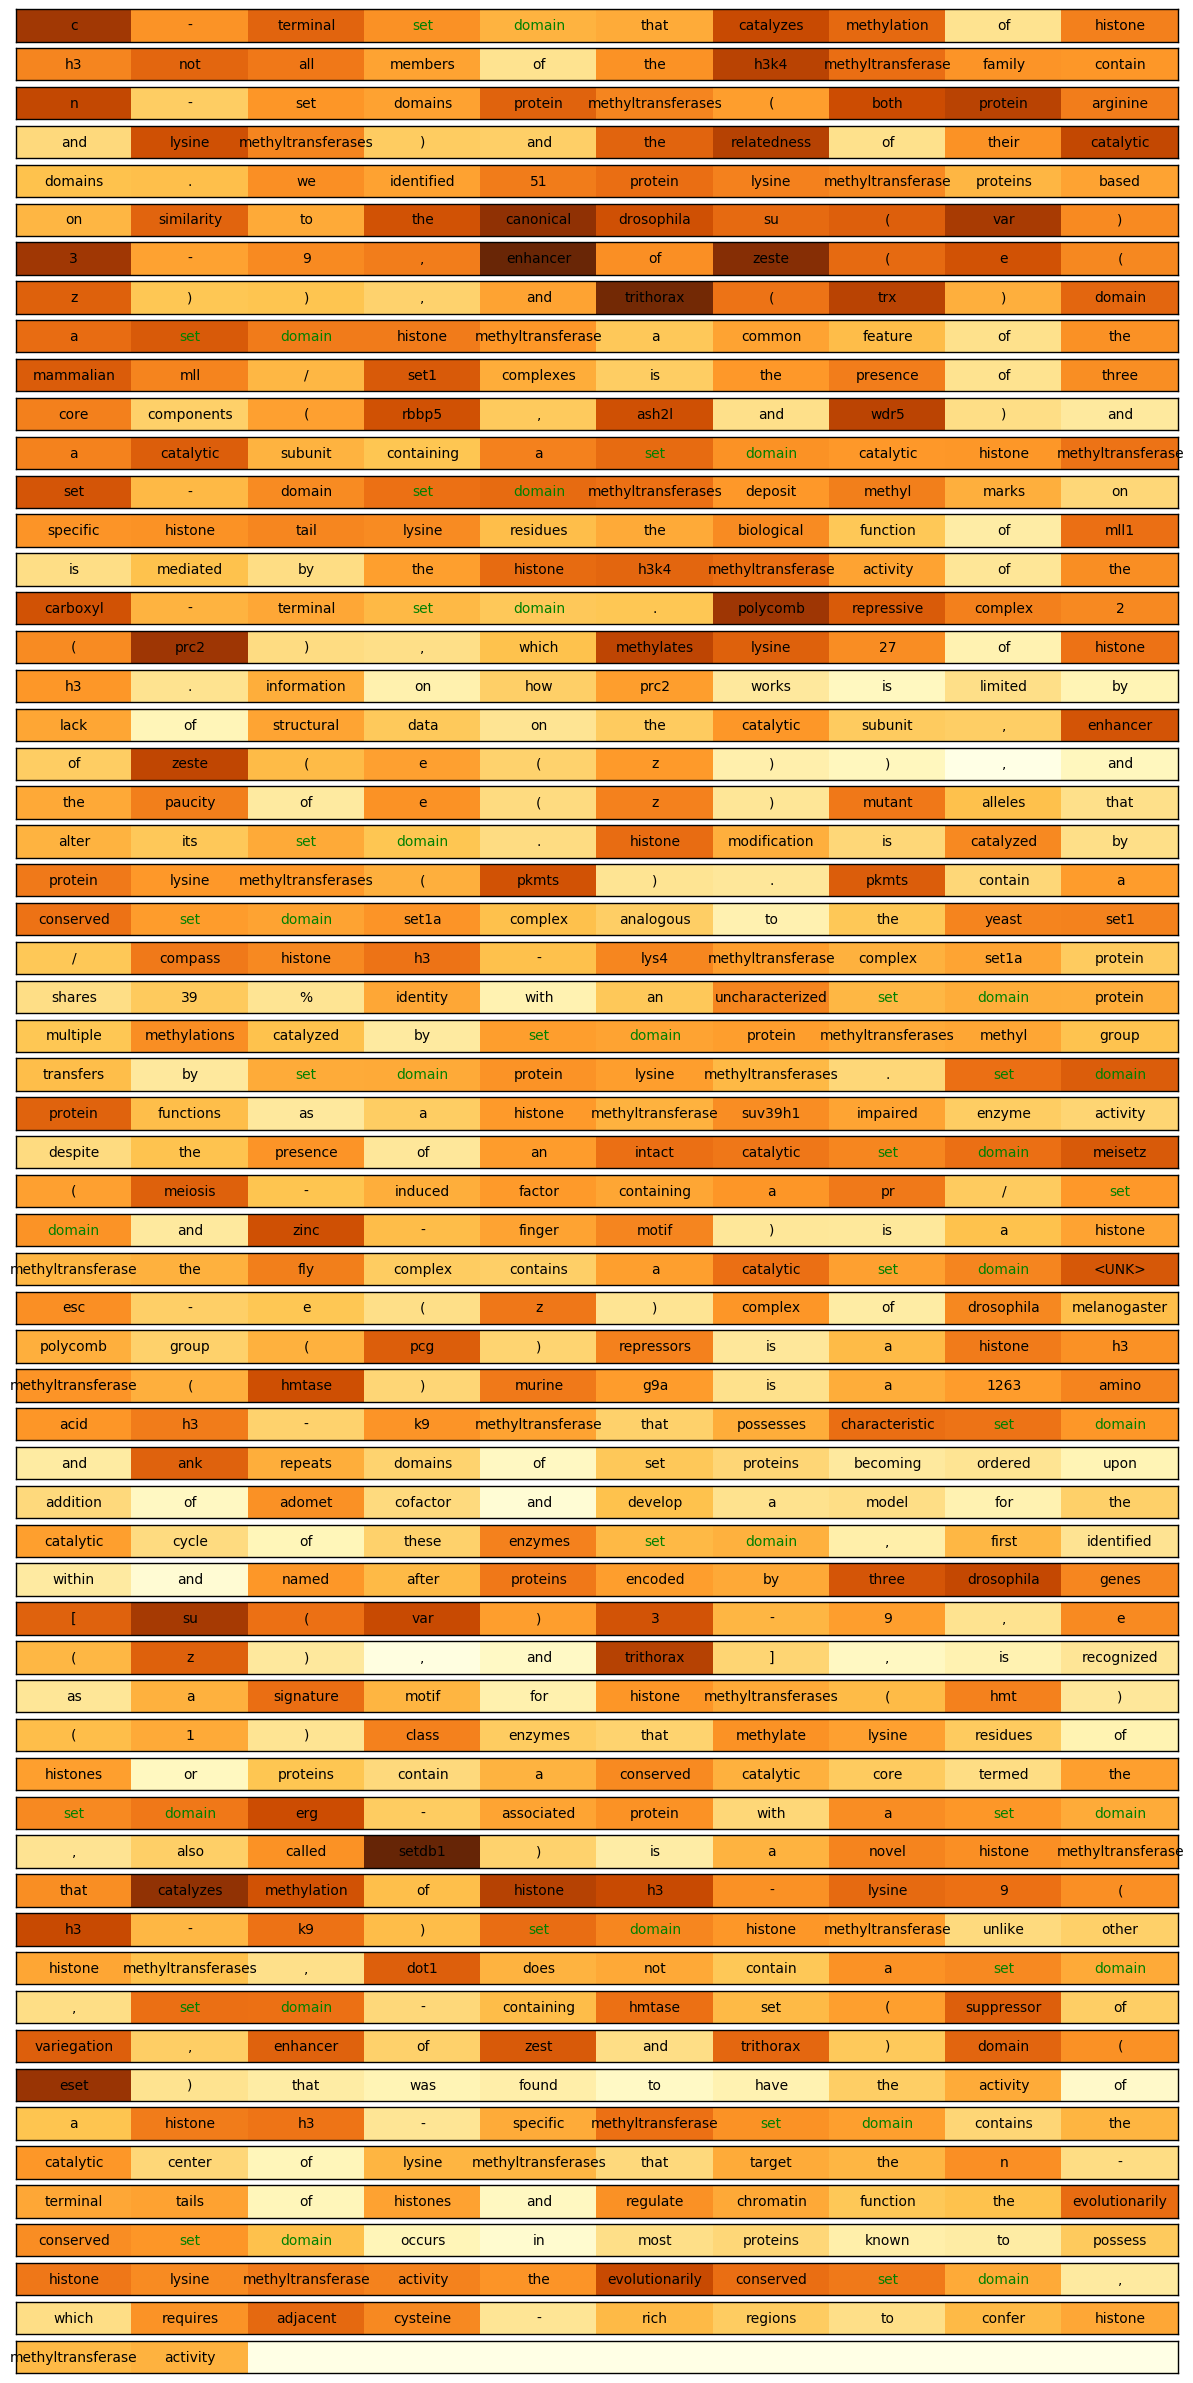

In [12]:
correct_tokens = find_correct_tokens(prediction.question)

text_heatmap(tokens, prediction.start_scores, correct_tokens)

In [13]:
# TODO
#start_token_mask = np.zeros(len(tokens), dtype=np.bool)
#start_token_mask[prediction.starts[0]] = True

#text_heatmap(tokens, prediction.end_scores[0], start_token_mask)

In [14]:
prediction.end_scores.shape

(844,)